# Experiment Setup

* This notebook aims at setting up experiment scenarios.

In [1]:
import os
import sys

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
CODE_DIR = os.path.join(PROJECT_HOME, "code")
print("The code directory is located at", CODE_DIR)
sys.path.append(CODE_DIR)

The code directory is located at ./../../code


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.vectorized
import shapely.ops as shapely_ops

from glob import glob
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

In [3]:
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries
from py_indoor_loc.extract.wifi_fingerprint import extract_fingerprint_df

In [4]:
%matplotlib inline

## Fingerprint Extraction

In [92]:
site_id = "5da138b74db8ce0c98bd4774"
floor_id = "B1"
data_dir = "../../data/wifi_fingerprint_manual/train"

In [109]:
def read_fingerprint_locations(site_id: str, floor_id: str, data_dir: str,
                               track_id_list: list[str] | None = None) -> np.ndarray:
  if track_id_list is not None:
    fingerprint_files = [f"{data_dir}/{site_id}/{floor_id}/{track_id}_wifi_fingerprint.csv"
                         for track_id in track_id_list]
  else:
    fingerprint_files = list(glob(f"{data_dir}/{site_id}/{floor_id}/*_wifi_fingerprint.csv"))


  fingerprint_df, _ = extract_fingerprint_df(fingerprint_files)
  return fingerprint_df[["x", "y"]].values

In [93]:
fingerprint_locations = read_fingerprint_locations(site_id, floor_id, data_dir)

The number of BSSIDs with at least 0 samples: 1537


100%|██████████| 219/219 [00:05<00:00, 39.03it/s]

The number of fingerprints: 4855


## Floormap Extraction

In [7]:
floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

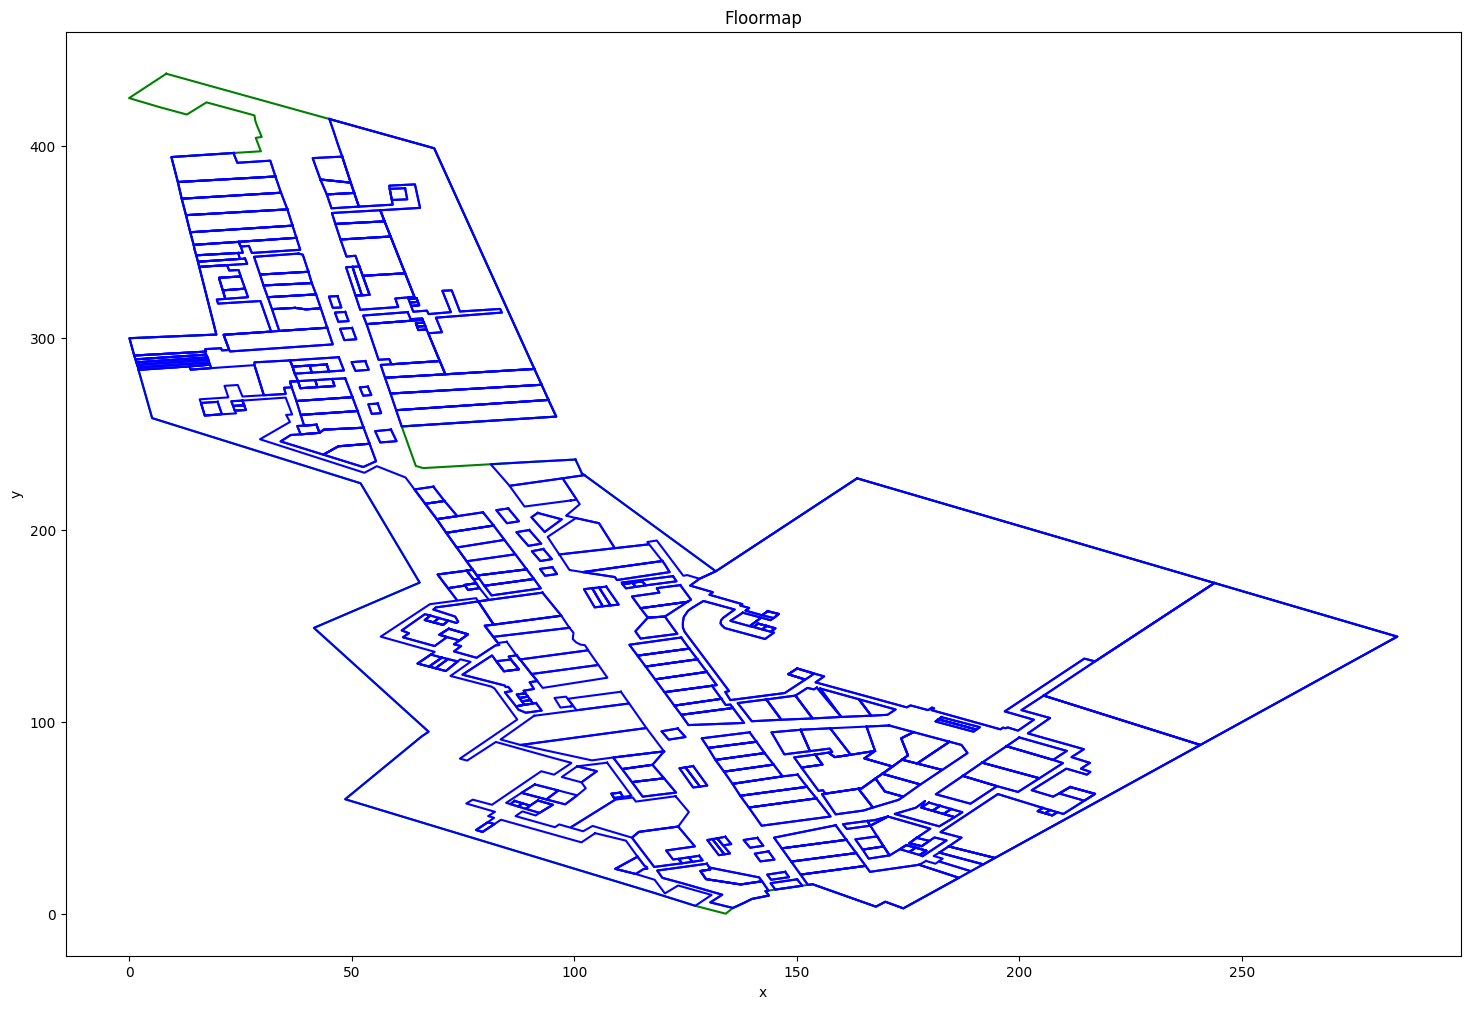

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

plt.ticklabel_format(useOffset=False)
plt.show()
plt.close()

## Coverage of Fingerprint's Locations

In [67]:
class FloorMapCoverageEstimator(object):
  def __init__(self, floor_polygons, store_polygons, width_meter, height_meter, grid_resolution: float = 2):
    self.__floor_polygons = floor_polygons
    self.__store_polygons = store_polygons
    self.__grid_resolution = grid_resolution
    self.__width_meter = width_meter
    self.__height_meter = height_meter

    self.__search_space = FloorMapCoverageEstimator._extract_hallway(floor_polygons, store_polygons)
    _ = self._make_grid()

  @property
  def width_meter(self):
    return self.__width_meter
  
  @property
  def height_meter(self):
    return self.__height_meter

  @property
  def grid_resolution(self):
    return self.__grid_resolution
  
  @property
  def search_space(self):
    return self.__search_space

  @classmethod
  def _extract_hallway(cls, floor_polygons, store_polygons):
    union_floor_polygon = shapely_ops.unary_union(floor_polygons)
    union_store_polygon = shapely_ops.unary_union(store_polygons)
    return union_floor_polygon.difference(union_store_polygon)

  def _make_grid(self):
    grid_xs_ = np.arange(0, self.width_meter, self.grid_resolution) + self.grid_resolution / 2
    grid_ys_ = np.arange(0, self.height_meter, self.grid_resolution) + self.grid_resolution / 2

    grid_x_, grid_y_ = np.meshgrid(grid_xs_, grid_ys_)
    search_space_mask = shapely.vectorized.contains(self.search_space, grid_x_, grid_y_)
    bin_x_, bin_y_ = grid_x_[search_space_mask], grid_y_[search_space_mask]
    
    self.bin_points = np.vstack((bin_x_, bin_y_)).T
    self.nearest_neighbors = NearestNeighbors(n_neighbors=4, algorithm="ball_tree", n_jobs=-1).fit(self.bin_points)

    return self
  
  def get_bin_coverage(self, points: np.ndarray, tol: float) -> np.ndarray:
    distances, indices = self.nearest_neighbors.kneighbors(points, n_neighbors=1)
    return np.unique(indices[distances <= tol])


In [68]:
fm_coverage_estimator = FloorMapCoverageEstimator(floor_polygons, store_polygons, width_meter, height_meter)

In [94]:
dists, indices = fm_coverage_estimator.nearest_neighbors.kneighbors(fingerprint_locations, n_neighbors=1)

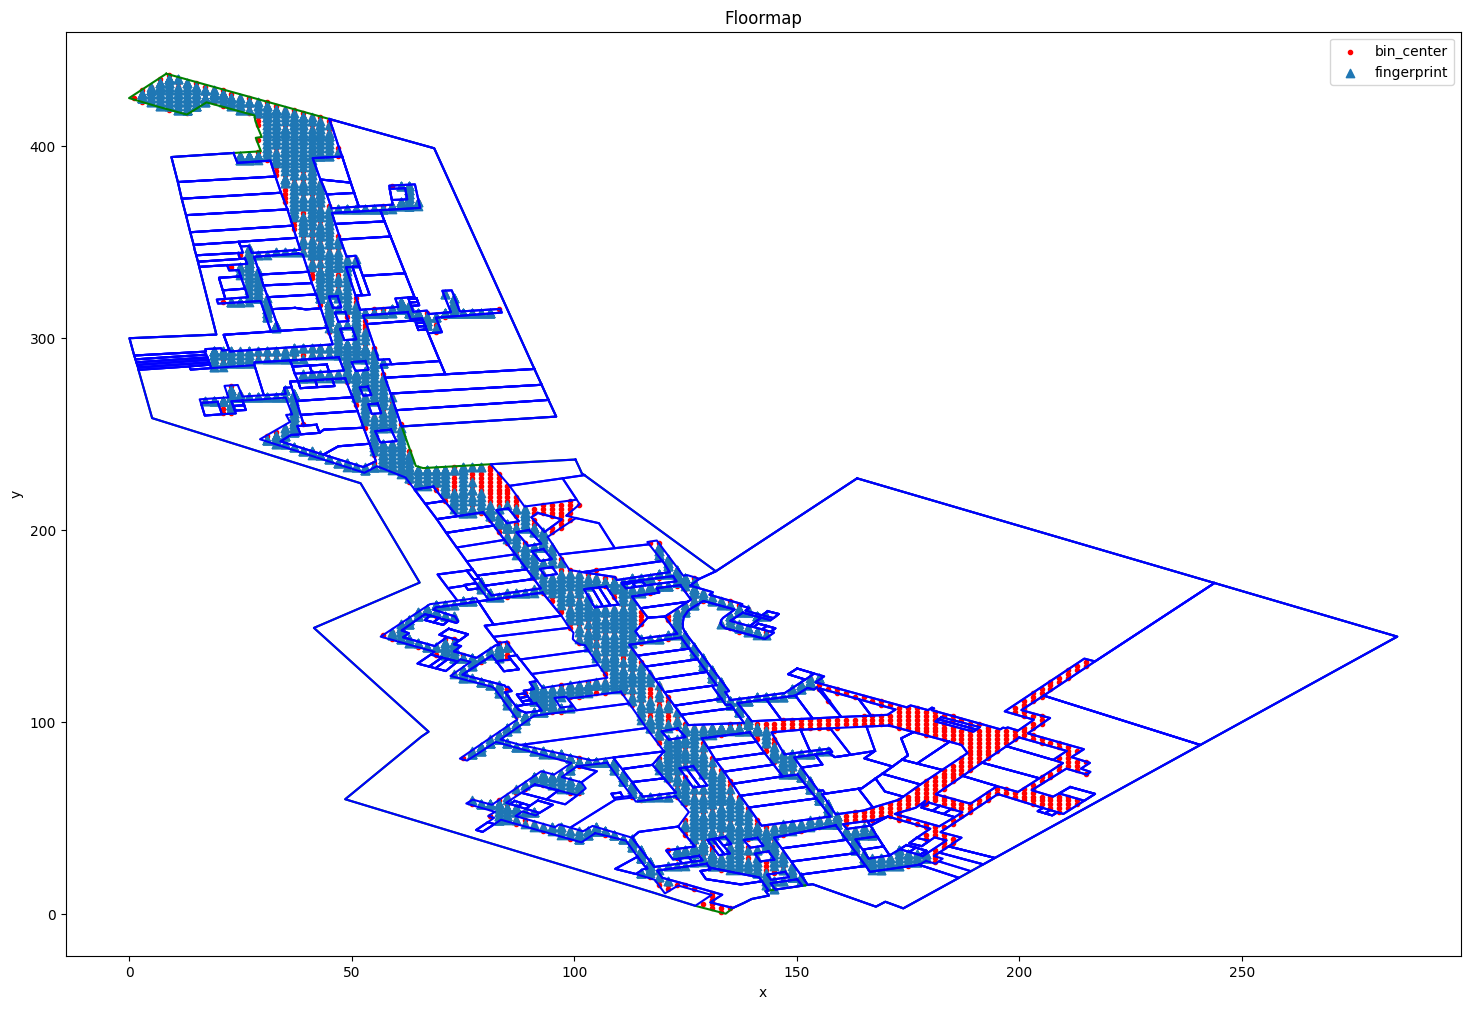

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

ax.scatter(fm_coverage_estimator.bin_points[:, 0], fm_coverage_estimator.bin_points[:, 1], marker=".", color="red", label="bin_center")
ax.scatter(fm_coverage_estimator.bin_points[indices[dists < 2.0]][:, 0], fm_coverage_estimator.bin_points[indices[dists < 2.0]][:, 1], marker="^", label="fingerprint")
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

In [97]:
coverage_pct = fm_coverage_estimator.get_bin_coverage(fingerprint_locations, tol=2.).shape[0] / fm_coverage_estimator.bin_points.shape[0]
print(f"Coverage percentage: {coverage_pct * 100:.2f}%")

## Track's Summary Statistics

In [17]:
def get_track_duration(waypoint_df: pd.DataFrame) -> float:
  """
  Compute the duration of track, in seconds.
  Args:
    waypoint_df: a pd.DataFrame of waypoints
  Returns:
    a float represents the duration of track, in seconds
  """
  sys_ts = waypoint_df["sys_ts"].values
  return (sys_ts[-1] - sys_ts[0]) / 1000

In [18]:
def get_track_length(waypoint_df: pd.DataFrame) -> float:
  """
  Compute the length of track, in meters.
  Args:
    waypoint_df: a pd.DataFrame of waypoints
  Returns:
    a float represents the length of track, in meters
  """
  xy = waypoint_df[["x", "y"]].values
  return np.linalg.norm(xy[1:] - xy[:-1], axis=1).sum()

In [19]:
waypoint_files = list(glob(f"../../data/wifi_fingerprint_manual/train/{site_id}/{floor_id}/*_waypoint.csv"))

In [20]:
def get_track_stats(waypoint_files: list[str]) -> pd.DataFrame:
  track_stats = []

  for waypoint_file_path in waypoint_files:
    track_name = os.path.basename(waypoint_file_path)[:-len("_waypoint.csv")]
    waypoint_df = pd.read_csv(waypoint_file_path)
    track_duration = get_track_duration(waypoint_df)
    track_length = get_track_length(waypoint_df)
    track_stats.append({
        "track_id": track_name,
        "duration": track_duration,
        "length": track_length,
    })

  return pd.DataFrame(track_stats)

In [22]:
track_stats_df_list = []

site_file_path_list = glob(f"../../data/wifi_fingerprint_manual/train/*")

for site_file_path in tqdm(site_file_path_list):
  site_id = os.path.basename(site_file_path)

  track_file_path_list = list(glob(site_file_path + "/*"))
  for track_file_path in track_file_path_list:
    floor_id = os.path.basename(track_file_path)
    
    waypoint_files = list(glob(track_file_path + "/*_waypoint.csv"))
    track_stats_df = get_track_stats(waypoint_files)
    track_stats_df["site_id"] = site_id
    track_stats_df["floor_id"] = floor_id

    track_stats_df_list.append(track_stats_df)

100%|██████████| 204/204 [00:56<00:00,  3.62it/s]


In [23]:
track_stats_df_all = pd.concat(track_stats_df_list)

In [24]:
!mkdir -p ../../data/output

In [25]:
track_stats_df_all.to_csv("../../data/output/track_stats_all.csv", index=False)

## Train/Test Split

* We perform a train/test split procedure based on the amount of time spent on collecting tracks.

In [31]:
track_stats_df_all["site_id"] = track_stats_df_all["site_id"].astype("category")
track_stats_df_all["floor_id"] = track_stats_df_all["floor_id"].astype("category")

In [89]:
track_stats_df_all.head()

,track_id,duration,length,site_id,floor_id
0,5db1692e5741f4000680a631,48.377,40.351840,5da138b74db8ce0c98bd4774,F5
1,5db2cc995741f4000680a8a2,11.595,12.750240,5da138b74db8ce0c98bd4774,F5
2,5db15a3de62491000652bd2c,20.354,18.758892,5da138b74db8ce0c98bd4774,F5
3,5db1690e5741f4000680a61d,28.636,36.052819,5da138b74db8ce0c98bd4774,F5
4,5db2ad2f5741f4000680a855,26.079,23.055595,5da138b74db8ce0c98bd4774,F5


In [103]:
def train_test_split_track(group_data: pd.DataFrame, test_size: float=0.2) -> pd.DataFrame:
  group_data = group_data[group_data["duration"] > 0].copy()
  
  group_data.sort_values("duration", ascending=False, inplace=True)
  duration_pct = group_data["duration"].values / group_data["duration"].values.sum()
  duration_csum = np.cumsum(duration_pct)
  group_data["dataset"] = "train"
  group_data.loc[duration_csum > 1.0 - test_size, "dataset"] = "test"

  return group_data

## Verify Data Overlapping

In [104]:
group_data = track_stats_df_all[
    (track_stats_df_all["site_id"] == "5da138b74db8ce0c98bd4774") &
    (track_stats_df_all["floor_id"] == "F5")]

splited_group_data = train_test_split_track(group_data)

In [111]:
site_id = "5da138b74db8ce0c98bd4774"
floor_id = "F5"

In [113]:
train_fingerprint_locations = read_fingerprint_locations(
  site_id=site_id, floor_id=floor_id, data_dir=data_dir, 
  track_id_list=splited_group_data[splited_group_data["dataset"] == "train"]["track_id"].values.tolist())

The number of BSSIDs with at least 0 samples: 1233


100%|██████████| 67/67 [00:03<00:00, 18.01it/s]

The number of fingerprints: 2332


In [121]:
test_fingerprint_locations = read_fingerprint_locations(
  site_id=site_id, floor_id=floor_id, data_dir=data_dir, 
  track_id_list=splited_group_data[splited_group_data["dataset"] == "test"]["track_id"].values.tolist())

The number of BSSIDs with at least 0 samples: 1113


100%|██████████| 66/66 [00:00<00:00, 66.90it/s]

The number of fingerprints: 610


In [114]:
floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

fm_coverage_estimator = FloorMapCoverageEstimator(floor_polygons, store_polygons, width_meter, height_meter)

In [118]:
train_covered_bins = fm_coverage_estimator.get_bin_coverage(train_fingerprint_locations, tol=2.)

In [120]:
print("Train coverage: {:.2f}".format(train_covered_bins.shape[0] / fm_coverage_estimator.bin_points.shape[0] * 100))

Train coverage: 77.40


In [123]:
test_covered_bins = fm_coverage_estimator.get_bin_coverage(test_fingerprint_locations, tol=2.)

In [124]:
print("Test coverage: {:.2f}".format(test_covered_bins.shape[0] / fm_coverage_estimator.bin_points.shape[0] * 100))

Test coverage: 26.73


In [127]:
len(set(test_covered_bins).intersection(set(train_covered_bins))) / len(set(test_covered_bins))

0.7988338192419825

In [37]:
test_size = 0.2
train_test_splited = []

for (site_id, floor_id), group_data in track_stats_df_all.groupby(["site_id", "floor_id"]):
  print(f"site_id={site_id}, floor_id={floor_id}")
  train_test_splited.append(train_test_split_track(group_data, test_size=test_size))

site_id=5a0546857ecc773753327266, floor_id=B1
site_id=5a0546857ecc773753327266, floor_id=F1
site_id=5a0546857ecc773753327266, floor_id=F2
site_id=5a0546857ecc773753327266, floor_id=F3
site_id=5a0546857ecc773753327266, floor_id=F4
site_id=5c3c44b80379370013e0fd2b, floor_id=B1
site_id=5c3c44b80379370013e0fd2b, floor_id=F1
site_id=5c3c44b80379370013e0fd2b, floor_id=F2
site_id=5c3c44b80379370013e0fd2b, floor_id=F3
site_id=5c3c44b80379370013e0fd2b, floor_id=F4
site_id=5c3c44b80379370013e0fd2b, floor_id=F5
site_id=5cd56865eb294480de7167b6, floor_id=F1
site_id=5cd56865eb294480de7167b6, floor_id=F2
site_id=5cd56865eb294480de7167b6, floor_id=F3
site_id=5cd56865eb294480de7167b6, floor_id=F4
site_id=5cd56865eb294480de7167b6, floor_id=F5
site_id=5cd56b5ae2acfd2d33b58544, floor_id=F1
site_id=5cd56b5ae2acfd2d33b58544, floor_id=F2
site_id=5cd56b5ae2acfd2d33b58544, floor_id=F3
site_id=5cd56b5ae2acfd2d33b58544, floor_id=F4
site_id=5cd56b5ae2acfd2d33b58546, floor_id=B1
site_id=5cd56b5ae2acfd2d33b58546, 

In [38]:
train_test_assignment = pd.concat(train_test_splited)

In [39]:
train_test_assignment.head()

,track_id,duration,length,site_id,floor_id,dataset
78,5e1580ccf4c3420006d520e0,107.339,90.026316,5a0546857ecc773753327266,B1,train
22,5e1580c51506f2000638fc6a,89.977,66.943107,5a0546857ecc773753327266,B1,train
73,5e15731ca280850006f3d011,88.834,55.475635,5a0546857ecc773753327266,B1,train
46,5e15731fa280850006f3d013,79.605,48.154400,5a0546857ecc773753327266,B1,train
62,5e157321a280850006f3d015,78.439,54.540528,5a0546857ecc773753327266,B1,train


In [40]:
train_test_assignment.to_csv("../../data/output/train_test_assignment.csv", index=False, header=True)